In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import codecs
import os
import urllib.request
import os
import nltk
nltk.download('punkt')

import gzip
import json
import pandas as pd
import numpy as np
from collections import Counter
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence

import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

import seaborn as sns



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


###Vamos a generar una clase que realiza multiples tareas como subir documentos al archivo del notbook, descargar la data de la web, trasnformarla en df, almacenarla o balnacear el df

In [ ]:
class DownloadAndTransformData():
  """clase que tiene varios metodos en relacion con la descarga transformacion y almacenado de la data"""
  def uploudFile(self,file_name: str, file_path: str,destination_path: str) ->None:
    """metodo que sube al archivo del notebook que se ejecuta el archivo que le indiquemos
      : param file_name:nombre del archivo que queremos subir
      : param file_path: ruta donde se encuenta el archivo
      : param destination_path: ruta del archivo del notebook
      return: None"""
    try:
      # Leemos el contenido del archivo como una cadena de texto
      with codecs.open(f'{file_path}{file_name}', 'r', encoding='utf-8') as f:
          file_content = f.read()
      # Escribe el contenido del archivo en un nuevo archivo con la misma ruta
      with codecs.open(destination_path, 'w', encoding='utf-8') as f:
          f.write(file_content)
      print('[INFO]Archivo cargado correctamente')
    except FileNotFoundError:
      print('[ERROR]No se ha podido realizar la carga del archivo')

  def downloadData(self, url:str , file_name:str)  -> None:
    """metodo que realiza la descarga del dataset
      : param url: direccion de la descarga
      : param file_name nombre con el qu lovamos a almacear
      return : None"""
    url = url
    file_name = file_name
    print(f"[INFO] Descargando archivo {file_name} ...")
    # Descargar el archivo desde la URL y guardarlo en un archivo local
    urllib.request.urlretrieve(url, file_name)
    print("[INFO] Archivo descargado exitosamente")

  def createDf(self, json_content) -> pd.DataFrame:
    """metodo que transforma el jason a df, creando las columas 'reviewText' y 'overall'
      : param json_content: json que contiene la data
      return : pd.DataFrame"""
    reviews = [item['reviewText'] for item in json_content]
    sentiments = [item['overall'] for item in json_content]
    df = pd.DataFrame({
        'review': reviews,
        'sentiment': sentiments
    })
    df.dropna(subset=['review', 'sentiment'], inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

  def createBalanceDF(self,df: pd.DataFrame, n_rows: int = 5000, balance: float = 0.5) -> pd.DataFrame:
    """funcion que genera un nuevo df a partir de otro mas grande, con el balance deseado si el 
    df inicial lo permite, para ello crea una nueva columna en df, sentiment_label, con una nueva
    clasificacion teniendo encuenta que las buenas (iguales o mayores de 3) y 1 el resto
    : param df: Dataframe
    : param n_rows: (int)tamaño del df final, por defecto 5000
    : param balance: (float) porcentaje de positivos, por defecto 50%
    return DafaFrame del tamaño y balance indicado"""
    df['sentiment_label'] = np.where(df['sentiment'] < 3, 1, 0)
    positive = df[df['sentiment_label'] == 0]
    negative = df[df['sentiment_label'] == 1]
    if len(positive) < n_rows * balance or len(negative) < n_rows * (1 - balance):
        raise ValueError('No hay suficientes filas para crear un dataset balanceado con los parámetros indicados')
    positive_sample = positive.sample(n=int(n_rows * balance), random_state=1, replace=True)
    negative_sample = negative.sample(n=int(n_rows * (1 - balance)), random_state=1, replace=True)
    df_concat = pd.concat([positive_sample, negative_sample]).reset_index(drop=True)
    #vamos a reorganizar de forma aleatoria las filas para que no salgan los sentiment_label reagrupados
    # Obtener un índice aleatorio
    idx = np.random.permutation(df_concat.index)
    # Reordenar las filas del DataFrame
    df_balanced = df_concat.iloc[idx] 
    print('[INFO] DataFrame creado correctamente')
    return df_balanced

  def saveDataFrame(self, df: pd.DataFrame, file_name: str = 'df_balanced.csv', path:str = '/content/drive/MyDrive/NLP_practica/datasets/') -> None:
    """metodo que guarda en el path indicado el df pasado por parámetro 
      : param df: df que queremos guardar
      : param file_name: nombre que le querenos dar al archivo a guardar
      : param path: ruta de guardad
      return: None"""
    if not os.path.exists(path):
      os.makedirs(path)
    df_balanced.to_csv(f'{path}{file_name}.csv', index=False)


#Instanciamos la clase DownloadAndTransformData para acceder a sus metodos
downloadclass =  DownloadAndTransformData()


In [ ]:
# Define la ruta del archivo en tu Google Drive, la ruta de destino y el nombre del archivo
file_path = '/content/drive/MyDrive/NLP_practica/'
file_name = 'graphics_nlp.py'
destination_path = '/content/graphics_nlp.py'
downloadclass.uploudFile(file_name= file_name, file_path= file_path, destination_path= destination_path)


[INFO]Archivo cargado correctamente


In [ ]:
#Importo la libreria creada para generar las gráficas
from graphics_nlp import Graphics

**En la siguiente celda, vamos a realizar la descarga del archivo reviews_Electronics_5.json.gz que continene las reseñas de productos electrónicos de amazon con el metodo downloadData**

In [ ]:
url = "http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Electronics_5.json.gz"
file_name = "reviews_Electronics_5.json.gz"
downloadclass.downloadData(url= url,file_name= file_name )

[INFO] Descargando archivo reviews_Electronics_5.json.gz ...
[INFO] Archivo descargado exitosamente


In [ ]:
# Abrimos el archivo comprimido y leemos sus líneas
with gzip.open(file_name, "rb") as f:
    file_lines = f.readlines()

json_content = []

# Decodificamos cada línea como un objeto JSON
for line in file_lines:
    json_content.append(json.loads(line.decode("utf-8")))

# Imprimimos la cantidad de reseñas en el archivo
print("Cantidad de reseñas: ", len(json_content))

Cantidad de reseñas:  1689188


In [ ]:
json_content[0]

{'reviewerID': 'AO94DHGC771SJ',
 'asin': '0528881469',
 'reviewerName': 'amazdnu',
 'helpful': [0, 0],
 'reviewText': 'We got this GPS for my husband who is an (OTR) over the road trucker.  Very Impressed with the shipping time, it arrived a few days earlier than expected...  within a week of use however it started freezing up... could of just been a glitch in that unit.  Worked great when it worked!  Will work great for the normal person as well but does have the "trucker" option. (the big truck routes - tells you when a scale is coming up ect...)  Love the bigger screen, the ease of use, the ease of putting addresses into memory.  Nothing really bad to say about the unit with the exception of it freezing which is probably one in a million and that\'s just my luck.  I contacted the seller and within minutes of my email I received a email back with instructions for an exchange! VERY impressed all the way around!',
 'overall': 5.0,
 'summary': 'Gotta have GPS!',
 'unixReviewTime': 13701

Ahora vamos a almacenar en listas el contenido de las reseñas y las puntuaciones para luego almacenarlo todo en un dataframe mediante el metodo createDF

In [ ]:
df = downloadclass.createDf(json_content= json_content)

In [ ]:
df.head()

,review,sentiment
0,We got this GPS for my husband who is an (OTR)...,5.0
1,"I'm a professional OTR truck driver, and I bou...",1.0
2,"Well, what can I say. I've had this unit in m...",3.0
3,"Not going to write a long review, even thought...",2.0
4,I've had mine for a year and here's what we go...,1.0


**Distribuión de las valoraciones**

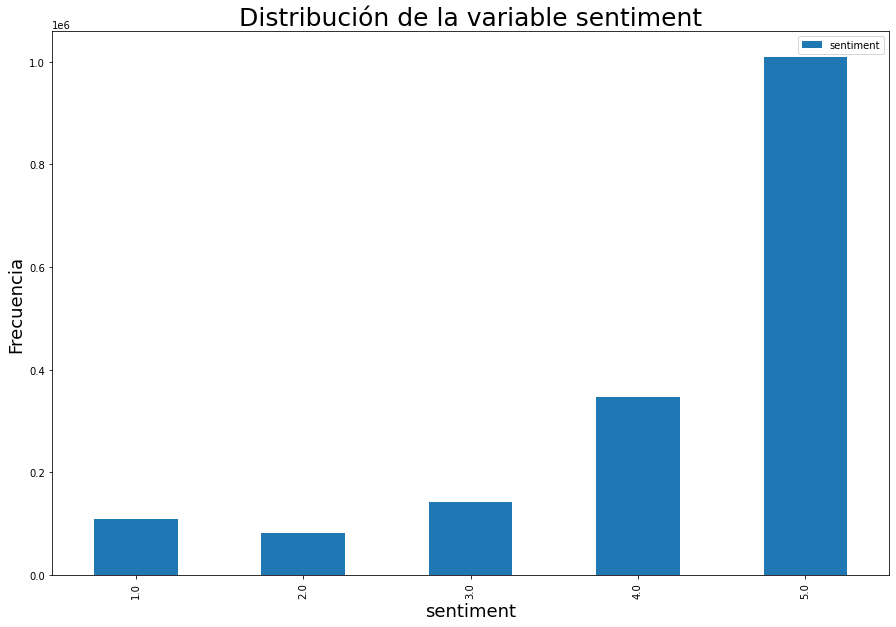

In [ ]:
#Creamos una instancia de la clase Graphics para llamar a los metodos que crean las gráficas
graphics = Graphics()
graphics.createSentimentsBarPlot(df = df)

Observamos que existe una distribución poco balanceada, vamos a analizar un poco mas el corpus y ademas a categorizar las reseñas en buenas o malas siendo 1 las menores de 3 estrellas y 0 las iguales o mayores de 3

In [ ]:
print(f'La puntuación máxima de las reseñas es: {max(df.sentiment)}')
print(f'La puntuación mínima de las reseñas es: {min(df.sentiment)}')
print(f'La puntuación media de las reseñas es: {round(df.sentiment.mean(),2)}')

La puntuación máxima de las reseñas es: 5.0
La puntuación mínima de las reseñas es: 1.0
La puntuación media de las reseñas es: 4.22


Vamos a hacer un pequeño análisis exploratorio de como se distribuyen los sentimientos en nuestro df

In [ ]:
print(f'Tenemos un corpus que contiene {len(df)} documentos')
print(f'Número de reseñas con sentimiento positivo: {len(df[df.sentiment_label == 0])}')
print(f'Número de reseñas con sentimiento negativo: {len(df[df.sentiment_label == 1])}')
print(f'%POS : {round(len(df[df.sentiment_label == 0])*100/len(df),2)}')
print(f'%NEG : {round(len(df[df.sentiment_label == 1])*100/len(df),2)}')

Tenemos un corpus que contiene 1689188 documentos
Número de reseñas con sentimiento positivo: 1498324
Número de reseñas con sentimiento negativo: 190864
%POS : 88.7
%NEG : 11.3


Puesto que se trata de un dataframe muy grande y desbalanceado, vamos a hacer uso del metodo createBalnacedDF para crear un df con el balance deseado

In [ ]:
df_balanced = downloadclass.createBalanceDF(df = df, n_rows= 5000, balance= 0.5)

[INFO] DataFrame creado correctamente


In [ ]:
df_balanced

,review,sentiment,sentiment_label
2648,"I bought these headphones, hoping that they wi...",2.0,1
2456,I keep it in my briefcase and use it for my ph...,5.0,0
4557,I will have to first admit that I only have on...,2.0,1
4884,I have to admit the 17 1/2 months I've used th...,2.0,1
92,"Wow, I haven't reviewed this yet? I've had it...",5.0,0
...,...,...,...
1593,Does everything except act as a wireless repea...,4.0,0
4060,A. Bought the system a day ago. Need to instal...,1.0,1
1346,For a while we've had AT&T; U-verse in our hom...,5.0,0
3454,Do not buy this drive for everyday use: it wil...,1.0,1


In [ ]:
print(f'Tenemos un corpus que contiene {len(df_balanced)} documentos')
print(f'Número de reseñas con sentimiento positivo: {len(df_balanced[df_balanced.sentiment_label == 0])}')
print(f'Número de reseñas con sentimiento negativo: {len(df_balanced[df_balanced.sentiment_label == 1])}')
print(f'%POS : {round(len(df_balanced[df_balanced.sentiment_label == 0])*100/len(df_balanced),2)}')
print(f'%NEG : {round(len(df_balanced[df_balanced.sentiment_label == 1])*100/len(df_balanced),2)}')

Tenemos un corpus que contiene 5000 documentos
Número de reseñas con sentimiento positivo: 2500
Número de reseñas con sentimiento negativo: 2500
%POS : 50.0
%NEG : 50.0


**Vamos a tokenizar los documentos, añadiendo una nueva columa al df (tokens)**

In [ ]:
df_balanced['tokens'] = df_balanced['review'].apply(lambda x: nltk.word_tokenize(x.lower()))

In [ ]:
df_balanced.head()

,review,sentiment,sentiment_label,tokens
1960,As someone else posted. In order to be able to...,4.0,0,"[as, someone, else, posted, ., in, order, to, ..."
2744,This is a simple white surface reflector. It ...,2.0,1,"[this, is, a, simple, white, surface, reflecto..."
1286,I want to start by stating up front that altho...,4.0,0,"[i, want, to, start, by, stating, up, front, t..."
3067,Would not buy again said heavy duty not cheap ...,1.0,1,"[would, not, buy, again, said, heavy, duty, no..."
1061,Perfect and there are two. Switch between sty...,5.0,0,"[perfect, and, there, are, two, ., switch, bet..."


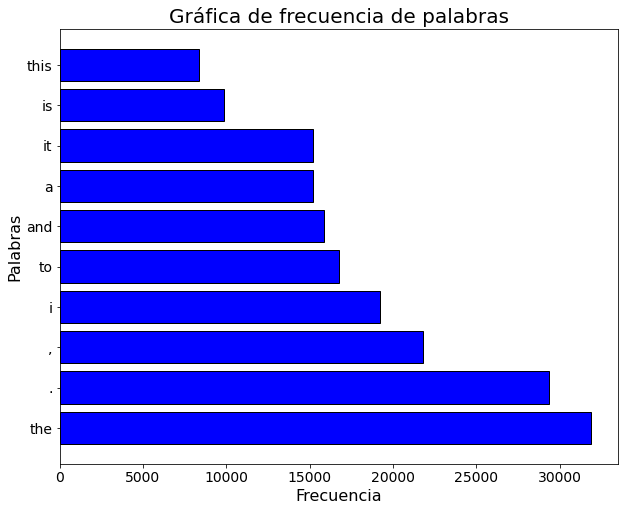

In [ ]:
# Crear la distribución de frecuencia
freqdist = nltk.FreqDist([token for tokens in df_balanced['tokens'] for token in tokens])

# Obtener las 10 palabras más frecuentes y sus frecuencias
top_words = freqdist.most_common(10)

#llamamos a la función createFrecuencieWordsBar de la clase Graphics para generar gráfico
graphics.createFrecuencieWordsBar(top_words)

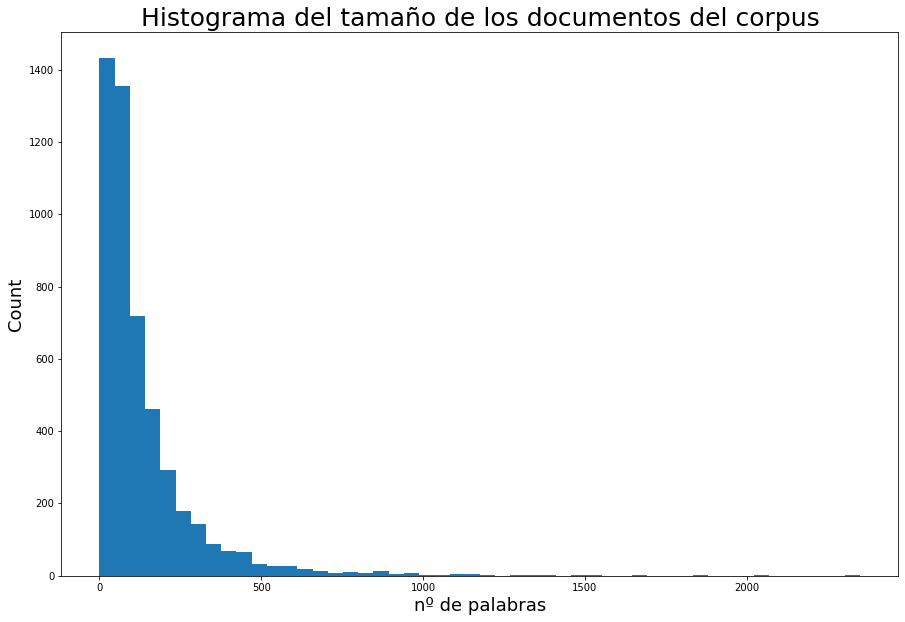

In [ ]:
# Análisis de longitud de texto de las reviews
df_balanced['text_length'] = df_balanced['tokens'].apply(lambda x: len(x))
graphics.createHistogram(df_balanced, 'text_length')


In [ ]:
mean_tokens = df_balanced['text_length'].mean()
std_tokens = df_balanced['text_length'].std()

print(f'La media de palabras por documento es: {round(mean_tokens,2)}')
print(f'Con una desviación de : {round(std_tokens,2)}')
print('\n<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<\n')
print('Visualizamos las 10 reviews con menos palabras:\n\nindex  n_palabras')
print(df_balanced['text_length'].sort_values().head(10))
print('\n<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<\n')
print('Visualizamos las 10 reviews con menos palabras:\n\nindex  n_palabras')
print(df_balanced['text_length'].sort_values(ascending=False).head(10))

La media de palabras por documento es: 136.43
Con una desviación de : 164.86

<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

Visualizamos las 10 reviews con menos palabras:

index  n_palabras
2053    0
634     0
4855    0
250     2
2042    2
1203    2
378     3
3235    4
3153    4
170     4
Name: text_length, dtype: int64

<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

Visualizamos las 10 reviews con menos palabras:

index  n_palabras
1448    2351
767     2067
792     1861
372     1666
217     1648
4697    1525
64      1500
4885    1392
4834    1354
1778    1339
Name: text_length, dtype: int64


Comprobamos que existen valoraciones de usuarios que no tienen reseña

In [ ]:
#Comprobamos uno de los indices que nos salen con review a cero
df_balanced.loc[df_balanced['text_length'].sort_values().index[0]]

review                
sentiment          5.0
sentiment_label      0
tokens              []
text_length          0
Name: 2053, dtype: object

In [ ]:
#Comprobamos uno de los indices que nos salen con review con mas de 2k palabras
df_balanced['review'].loc[df_balanced['text_length'].sort_values(ascending=False).index[0]]

'The GPS market has come a long way in the past few years. A decade ago, there were very few after-market GPS units, they were mostly expensive, and they were also mostly mediocre. The best units cost more than a thousand, and while they\'d get you from here to there, didn\'t feature a lot of bells and whistles. Factory installed GPS units--then limited mostly to high end cars--generally cost $2-3k.A growing number of portable GPS units have come to market in the past 5 or so years. Over time, the hardware has improved, the software has (for the best ones) gotten pretty good, and prices have (especially in the past year or so) dropped tremendously. (That last point--the tremendous drop in price--has forced many manufacturers out of the market. At this point, it is mostly dominated by names like TomTom, Magellan, and Garmin). There is also now competition from high end smart phones, most of which have a GPS unit built in.(Amazingly--or perhaps not--the cost of factory installed car GPS 

Ahora vamos a guardar el df creado para poder utilizarlo en otros notebooks

In [ ]:
# Especificamos la ruta de la carpeta en donde se guardará, si la carpeta aun no existe la creará
path = '/content/drive/MyDrive/NLP_practica/datasets'
downloadclass.saveDataFrame(df = df_balanced,file_name='df_balanced.csv' )



**Ahora vamos a realizar el análisis de los ngrams**

In [ ]:
from nltk.util import ngrams

# Definir una función para crear n-gramas de una lista de tokens
def create_ngrams(tokens, n):
    # Generar n-gramas a partir de los tokens
    ngram_list = list(ngrams(tokens, n))
    return ngram_list

# Aplicar la función a cada lista de tokens en la columna "tokens"
df_balanced["2grams"] = df_balanced["tokens"].apply(lambda tokens: create_ngrams(tokens, 2))
df_balanced["3grams"] = df_balanced["tokens"].apply(lambda tokens: create_ngrams(tokens, 3))



**2Gram**

In [ ]:
# Crear una lista que contenga todos los n-gramas del DataFrame
_2gram_list = [ngram for ngram_row in df_balanced["2grams"] for ngram in ngram_row]
# Obtener la frecuencia de cada n-grama
_2gram_freq = FreqDist(_2gram_list)
# Obtener los 10 n-gramas más frecuentes
top_2grams = _2gram_freq.most_common(10)

# Imprimir los n-gramas más frecuentes
print('Visualizamos los bigrams mas frecuentes:\n')

  for ngram, freq in top_2grams:
      print(f"{ngram}: {freq}")



Visualizamos los bigrams mas frecuentes:

('.', 'i'): 5242
('.', 'the'): 2728
(',', 'and'): 2433
(',', 'but'): 2416
('of', 'the'): 2139
('.', 'it'): 2087
(',', 'i'): 1944
('i', 'have'): 1680
('on', 'the'): 1633
('it', "'s"): 1485


**3Grams**

In [ ]:
# Crear una lista que contenga todos los n-gramas del DataFrame
_3gram_list = [ngram for ngram_row in df_balanced["3grams"] for ngram in ngram_row]
# Obtener la frecuencia de cada n-grama
_3gram_freq = FreqDist(_3gram_list)
# Obtener los 10 n-gramas más frecuentes
top_3grams = _3gram_freq.most_common(10)

# Imprimir los n-gramas más frecuentes
print('Visualizamos los bigrams mas frecuentes:\n')

for ngram, freq in top_3grams:
    print(f"{ngram}: {freq}")


Visualizamos los bigrams mas frecuentes:

('&', '#', '34'): 539
('#', '34', ';'): 539
('.', 'i', 'have'): 489
('i', 'do', "n't"): 427
(',', 'but', 'i'): 368
('.', 'it', "'s"): 363
('.', 'it', 'is'): 351
(',', 'but', 'it'): 304
('.', 'if', 'you'): 288
('this', 'is', 'a'): 286


Observamos que hay que hacer limpia de muchos signos y de palabras que no aportan peso al análisis

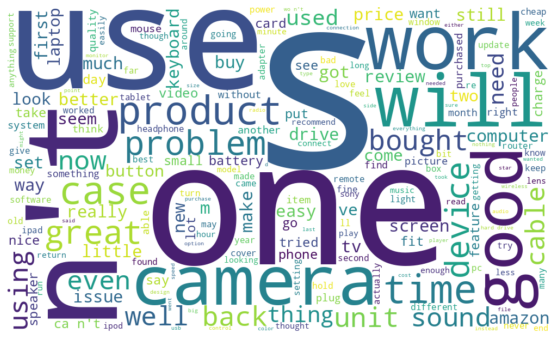

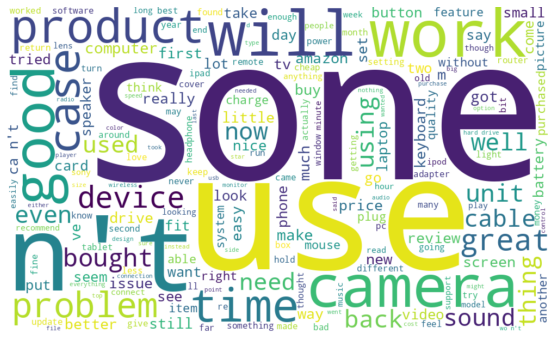

In [ ]:
# Convertir la lista de tokens en una cadena de texto
text = " ".join(df_balanced["tokens"].apply(lambda tokens: " ".join(tokens)))
#llamamos a la funcion createWorldCloud de la clase Graphics
graphics.createWorldCloud(text)



###Ahora vamos a entrenar un modelo word2vec para realizar la representacion de embedding de las palabras que le indiquemos

In [ ]:
#Creamos una lista de listas con las reseñas tokenizadas
sentences = [[token for token in doc] for doc in df_balanced['tokens']]

#Construimos el vocabulario del modelo
model = Word2Vec(size=100, window=5, min_count=1, workers=4)
model.build_vocab(sentences)

# Entrenar el modelo Word2Vec
model.train(sentences, total_examples=len(sentences), epochs=10)

(4895111, 6821300)

In [ ]:
keys = ['work','use','good','product','problem']

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in model.wv.most_similar(word, topn=10):
        words.append(similar_word)
        embeddings.append(model.wv[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

In [ ]:
#Reducimos la dimensionalidad 
tsne_model_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
embeddings_2d = np.array(tsne_model_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

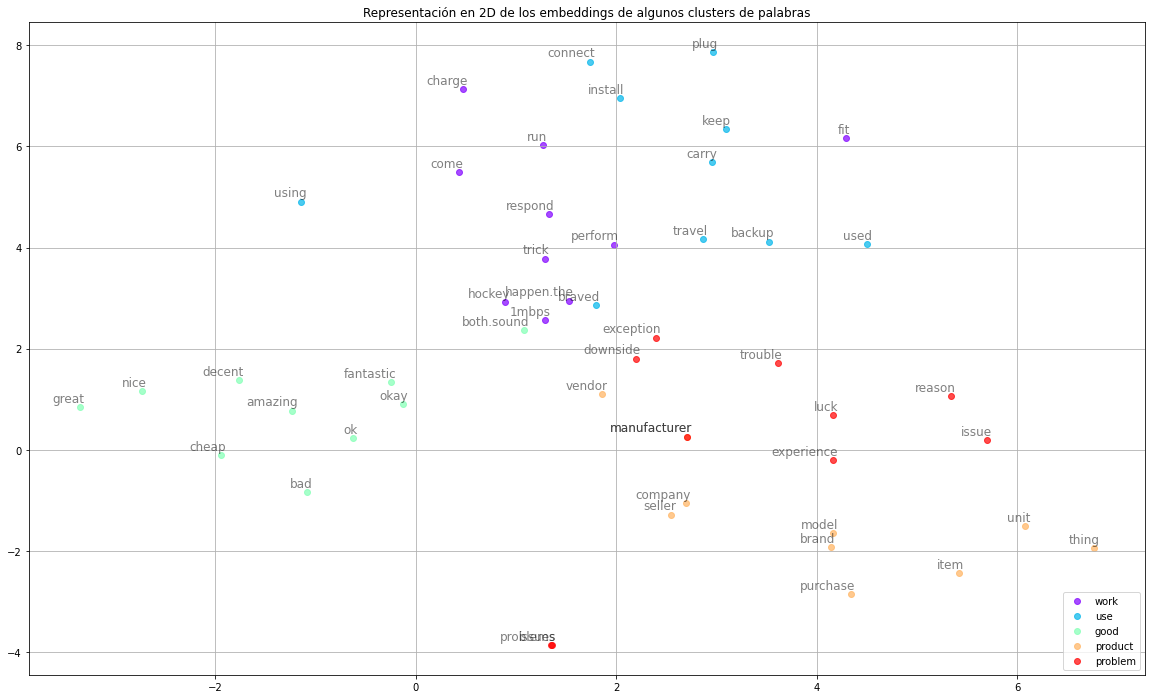

In [ ]:
graphics.tsnePlotSimilarWords(keys, embeddings_2d, word_clusters)

En base a análisis exploratorio tenemos que realizar el preprocesamiento de los datos, ya que en los analisis anteriores existen muchas palabras que no aportan nada al análisis, asi como los signos de puntuación que tambien tendremos que eliminar mediante diferentes técnicas